In [1]:
# usual loading

import matplotlib.pyplot as plt
import numpy as np

# extra loading
from pathlib import Path
from xnemogcm import get_metrics, open_nemo, open_domain_cfg
from xnemogcm.metrics import compute_missing_metrics
import xgcm
import xarray as xr

In [2]:
# define some defaults
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r" # \"*_r\" is reverse of standard colour\n",
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

label_str = "abcdefghijklmnopqrstuvwxyz"

import sys
scivis_path = "/home/jclmak/Documents/python/scivis_cm/KeyColormaps/"
sys.path.append(scivis_path)
import cm_xml_to_matplotlib as scivis_cm
# wave4_cm = scivis_cm.make_cmap('/home/jclmak/Documents/python/firedrake/geometric/4-3wbgy.xml')
wave4_cm = scivis_cm.make_cmap(scivis_path + "3Wbgy5.xml")

# some magic things for editing
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import make_axes
import matplotlib.ticker as mticker

# use this for regridding, to help with using cartopy
import xesmf
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
data_dir = Path("/home/jclmak/Downloads/nemo42_orca2/alp006/")

domcfg = open_domain_cfg(datadir=data_dir)

file_T = open_nemo(domcfg=domcfg, files=data_dir.glob('*grid_T.nc'))
file_U = open_nemo(domcfg=domcfg, files=data_dir.glob('*grid_U.nc'))
file_V = open_nemo(domcfg=domcfg, files=data_dir.glob('*grid_V.nc'))
file_W = open_nemo(domcfg=domcfg, files=data_dir.glob('*grid_W.nc'))

In [19]:
Static_e3 = True
metrics_dict = get_metrics(domcfg)
if Static_e3: # only as placeholder for completeness
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_1d']
print(metrics_dict)
grid = xgcm.Grid(domcfg, metrics=metrics_dict, periodic=["X"])  # specify periodicity with a list

bd = {'boundary':'fill', 'fill_value':0}

{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_1d']}


In [77]:
# psi = +d(psi) / dx
psi_v = ( +grid.cumint( (file_V["vo"][0, :, :, :] * domcfg["e3v_0"]).sum("z_c"), "X", **bd )
         * domcfg["fmask"][0, :, :] * 1e-6
        )

# psi = -d(psi) / dy
psi_u = ( -grid.cumint( (file_U["uo"][0, :, :, :] * domcfg["e3u_0"]).sum("z_c"), "Y", **bd )
         * domcfg["fmask"][0, :, :] * 1e-6
        )

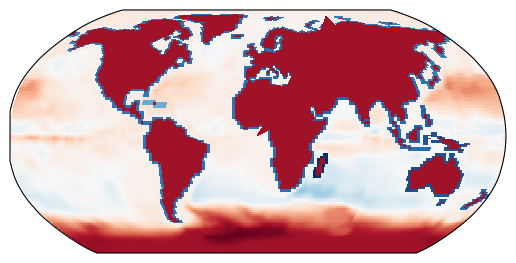

In [79]:
ax = plt.axes(projection=ccrs.Robinson())
cs = ax.pcolormesh(psi_u["glamf"], psi_u["gphif"], psi_u, transform=ccrs.PlateCarree())

In [51]:
# regrid with xESMF (probably need this if contourf wants to be used)
ds_out = xesmf.util.grid_global(1, 1)  # 1 x 1 deg
regridder = xesmf.Regridder(psi_u.rename({"glamf": "lon", "gphif": "lat"}), ds_out, "bilinear", 
                            ignore_degenerate=True)  # from https://github.com/JiaweiZhuang/xESMF/issues/78
blob = regridder(psi_u)

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:450: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


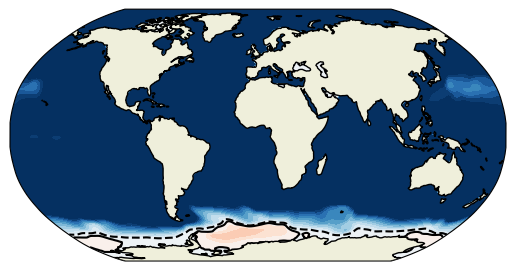

In [71]:
ax = plt.axes(projection=ccrs.Robinson())
ax.contourf(blob["lon"], blob["lat"], blob, 
            levels=np.arange(-100, 110, 10), extend="both", 
            transform=ccrs.PlateCarree())
ax.contour(blob["lon"], blob["lat"], blob,
           levels=[-10, 0], colors="k",
           transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')

In [4]:
def plot_2dmap_generic(blob, ax, res=(1, 1), lines = False, **misc_opts):
    """
    Do a generic 2d map plot using contourf, relies on regridding (XESMF regridding on a default 1 x 1 regular 
    lat-lon grid) and uses the regridded lon/lat.
    
    Expects an input where input blob already has the appropriate lon/lat variable swapped out to lon/lat 
    (e.g. "glamt" -> "lon").
    
    Reduce res (e.g. res=(4, 4)) to speed up the regridding a bit, such as testing formatting of plots.
    """
    
    pcarree = ccrs.PlateCarree()
    
    # do some regridding
    ds_out = xesmf.util.grid_global(res[0], res[1])  # 1 x 1 deg
    regridder = xesmf.Regridder(blob, ds_out, "bilinear", 
                                ignore_degenerate=True)  # from https://github.com/JiaweiZhuang/xESMF/issues/78
    blob = regridder(blob)

    if lines:
        lines = ax.contour(blob.lon, blob.lat, blob, transform=ccrs.PlateCarree(), **misc_opts)
        return lines

    else:
        mesh = ax.contourf(blob.lon, blob.lat, blob, transform=ccrs.PlateCarree(), **misc_opts)
        ax.set_global()
        ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')

    # magic command to get rid of white lines in contourf outputs
    for c in mesh.collections:
        c.set_edgecolor("face")

    return mesh

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


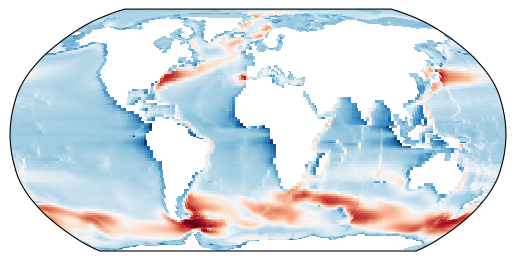

In [5]:
lonT = file_T["glamt"]
latT = file_T["gphit"]
eke = file_T["eke"][0, :, :]

# pcolormesh is fine, but contourf needs regridding probably
ax = plt.axes(projection=ccrs.Robinson())
ax.pcolormesh(lonT, latT, np.log10(eke), transform=ccrs.PlateCarree())

In [22]:
# regrid with xESMF (probably need this if contourf wants to be used)
ds_out = xesmf.util.grid_global(1, 1)  # 1 x 1 deg
regridder = xesmf.Regridder(eke.rename({"glamt": "lon", "gphit": "lat"}), ds_out, "bilinear", 
                            ignore_degenerate=True)  # from https://github.com/JiaweiZhuang/xESMF/issues/78
blob = regridder(eke)

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:450: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:450: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


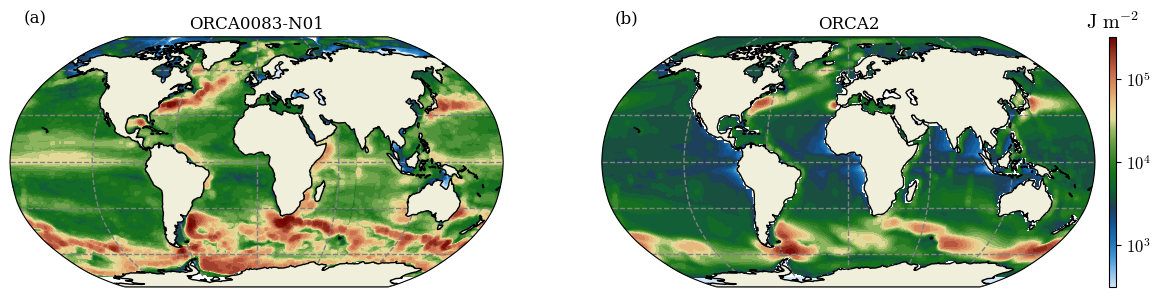

In [56]:
# energy in appropriate units

rho0 = 1026.0 # value used in NEMO

vmin, vmax = 2.5, 5.5
# raw plots of the eddy energy in logarithmic scale
misc_opts = {"levels" : np.linspace(vmin, vmax, 31),
             "cmap"   : wave4_cm,
             "extend" : "both"}
norm = Normalize(vmin = vmin, vmax = vmax)
colors = misc_opts["cmap"](np.linspace(0, 1, misc_opts["cmap"].N))
cmap2 = LinearSegmentedColormap.from_list('Upper Half', colors)

nrows = 1
ncols = 2
fig, axes = plt.subplots(figsize = (14, 4), nrows = nrows, ncols = ncols)

# ORCA012 output

orca12_dir = "/home/jclmak/data/NEMO_data/ORCA0083-N01/downsized_12/standard_binning_200/"
ee_zint = xr.open_dataset(orca12_dir + "eke_zint_tave.nc")
dummy = ee_zint["eke_zint"].values  # soft link here...
years = ["2006", "2007", "2008", "2009", "2010"]
for i in range(len(years)):
    dummy1 = xr.open_dataset(orca12_dir + "epe_zint_tave_%s.nc" % years[i])
    dummy += dummy1["epe_zint"].values / len(years)  # ...so result is already part of a dataarray?
ds_out = xesmf.util.grid_global(1, 1)  # 1 x 1 deg
regridder = xesmf.Regridder(ee_zint.rename({"nav_lon": "lon", "nav_lat": "lat"}), ds_out, "bilinear", 
                            ignore_degenerate=True)  # from https://github.com/JiaweiZhuang/xESMF/issues/78
blob = regridder(ee_zint)

axes[0] = plt.subplot(1, 2, 1, projection = ccrs.Robinson())
mesh = axes[0].contourf(blob.lon, blob.lat, np.log10(rho0 * blob.eke_zint), 
                        transform=ccrs.PlateCarree(), **misc_opts)
axes[0].set_global()
axes[0].add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')

# magic command to get rid of white lines in contourf outputs
for c in mesh.collections:
    c.set_edgecolor("face")
    
gl = axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, color='gray', linestyle='--')
axes[0].set_title("ORCA0083-N01", fontsize = 12)


# ORCA2 output

axes[1] = plt.subplot(1, 2, 2, projection = ccrs.Robinson())
mesh = plot_2dmap_generic(np.log10(rho0 * eke.rename({"glamt": "lon", "gphit": "lat"})), axes[1], 
                          res=(1, 1), **misc_opts)
gl = axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', linestyle='--')
axes[1].set_title("ORCA2", fontsize = 12)

# create the axes by grabbing the bounding boxes of the individual plot axes
pos_bot = axes[ncols - 1].get_position()
pos_top = axes[ncols - 1].get_position()
ax_cb = fig.add_axes([pos_bot.x1 + 0.01,
                      pos_bot.y0,
                      0.005,
                      pos_top.y1 - pos_bot.y0])
cb = ColorbarBase(ax_cb, cmap = cmap2, norm = norm)
cb.ax.set_title(r"$\mathrm{J}\ \mathrm{m}^{-2}$")
cb.set_ticks(np.arange(3, 6, 1))
cb.set_ticklabels([r"$10^{%s}$" % i for i in range(3, 6, 1)])

for i in range(nrows):
    for j in range(ncols):
        ind = (i * ncols) + j + 1
        axes[ind-1].text(0.05, 1.075, r'(%s)' % label_str[ind - 1], transform = axes[ind-1].transAxes,
                ha = 'center', va = 'center')

# plt.subplots_adjust(wspace = 0.05)

In [ ]:
# barotropic streamfunction